# ML Analysis: Task Type Classification

This notebook demonstrates a comprehensive machine learning workflow to classify task types based on text prompts.

## 1. Data Loading and Overview

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Load the dataset
df = pd.read_csv('data.csv')

# Display basic info
print(f"Dataset shape: {df.shape}")
print(f"\nFirst few rows:")
df.head(10)

Dataset shape: (5000, 2)

First few rows:


,prompt,task_type
0,Summarize the internal wiki page from yesterday.,text_summarization
1,Create a C++ class that automates database bac...,code_task
2,Condense this technical document to its essent...,text_summarization
3,Summarize this Jira ticket into one sentence.,text_summarization
4,Explain how to sorts a list of dictionaries by...,explanation_task
5,Generate a template announcement for onboardin...,text_generation
6,Convert this Bash script into a Python Pandas ...,code_task
7,Optimize this Kotlin function for improve perf...,code_task
8,Summarize this requirements specification for ...,text_summarization
9,Optimize this JavaScript function for follow c...,code_task


In [22]:
# Data information
print("Dataset Info:")
print(df.info())
print("\nMissing values:")
print(df.isnull().sum())
print("\nDuplicates:")
print(f"Number of duplicate rows: {df.duplicated().sum()}")

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   prompt     5000 non-null   object
 1   task_type  5000 non-null   object
dtypes: object(2)
memory usage: 78.2+ KB
None

Missing values:
prompt       0
task_type    0
dtype: int64

Duplicates:
Number of duplicate rows: 0


## 2. Exploratory Data Analysis (EDA)

In [23]:
# Class distribution
print("Class Distribution:")
class_dist = df['task_type'].value_counts()
print(class_dist)
print(f"\nClass percentages:")
print(df['task_type'].value_counts(normalize=True) * 100)

Class Distribution:
task_type
code_task             1724
text_generation       1396
text_summarization    1295
explanation_task       585
Name: count, dtype: int64

Class percentages:
task_type
code_task             34.48
text_generation       27.92
text_summarization    25.90
explanation_task      11.70
Name: proportion, dtype: float64


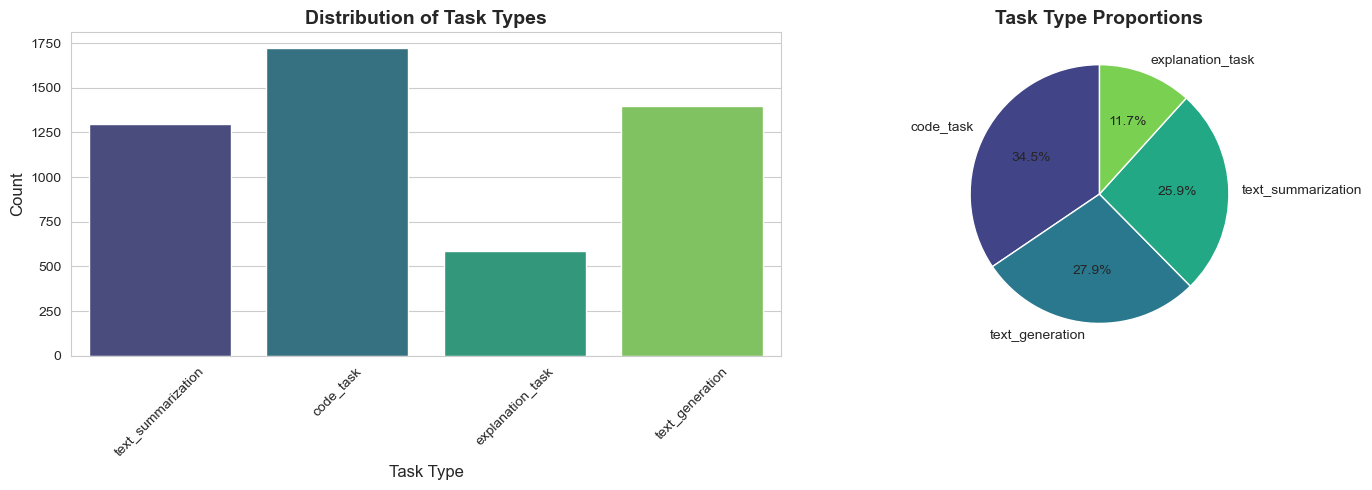

In [24]:
# Visualization 1: Class distribution bar plot
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Count plot
sns.countplot(x='task_type', data=df, ax=axes[0], palette='viridis')
axes[0].set_title('Distribution of Task Types', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Task Type', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)

# Pie chart
colors = sns.color_palette('viridis', len(class_dist))
axes[1].pie(class_dist, labels=class_dist.index, autopct='%1.1f%%', colors=colors, startangle=90)
axes[1].set_title('Task Type Proportions', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

In [25]:
# Text length analysis
df['prompt_length'] = df['prompt'].str.len()
df['word_count'] = df['prompt'].str.split().str.len()

print("Text Statistics:")
print(df[['prompt_length', 'word_count']].describe())

# Group by task type
print("\nAverage text length by task type:")
print(df.groupby('task_type')[['prompt_length', 'word_count']].mean().round(2))

Text Statistics:
       prompt_length   word_count
count     5000.00000  5000.000000
mean        52.94740     8.347000
std          9.47408     1.718482
min         26.00000     5.000000
25%         46.00000     7.000000
50%         53.00000     8.000000
75%         59.00000     9.000000
max         91.00000    17.000000

Average text length by task type:
                    prompt_length  word_count
task_type                                    
code_task                   53.73        9.02
explanation_task            54.20        8.90
text_generation             51.35        8.17
text_summarization          53.06        7.39


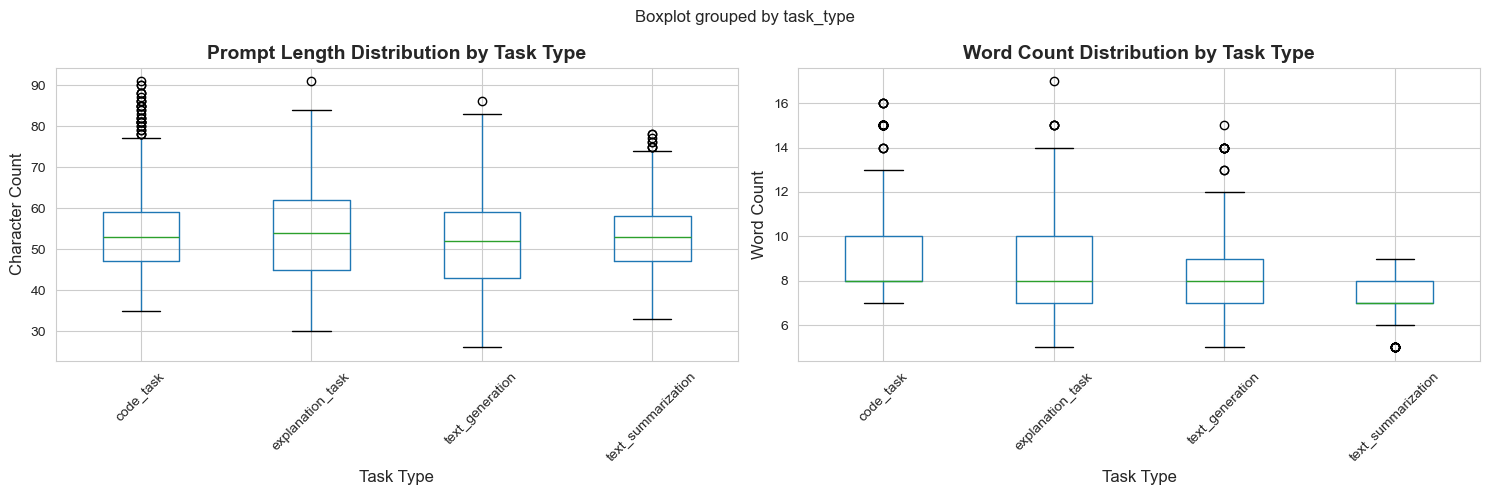

In [26]:
# Visualization 2: Text length distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Character length by task type
df.boxplot(column='prompt_length', by='task_type', ax=axes[0])
axes[0].set_title('Prompt Length Distribution by Task Type', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Task Type', fontsize=12)
axes[0].set_ylabel('Character Count', fontsize=12)
plt.sca(axes[0])
plt.xticks(rotation=45)

# Word count by task type
df.boxplot(column='word_count', by='task_type', ax=axes[1])
axes[1].set_title('Word Count Distribution by Task Type', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Task Type', fontsize=12)
axes[1].set_ylabel('Word Count', fontsize=12)
plt.sca(axes[1])
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## 3. Data Preprocessing

We'll prepare the text data using TF-IDF vectorization.

In [27]:
# Prepare features and target
X = df['prompt']
y = df['task_type']

# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(
    max_features=5000,
    stop_words='english',
    ngram_range=(1, 2),  # Use unigrams and bigrams
    min_df=2,  # Ignore terms that appear in less than 2 documents
    max_df=0.95  # Ignore terms that appear in more than 95% of documents
)

# Transform the text data
X_tfidf = tfidf.fit_transform(X)

print(f"TF-IDF matrix shape: {X_tfidf.shape}")
print(f"Number of features: {len(tfidf.get_feature_names_out())}")

TF-IDF matrix shape: (5000, 1871)
Number of features: 1871


In [28]:
# Get top terms for each class
from sklearn.feature_extraction.text import TfidfVectorizer

print("Top 10 terms for each task type:\n")
for task in df['task_type'].unique():
    # Get prompts for this task
    task_prompts = df[df['task_type'] == task]['prompt']
    
    # Vectorize
    task_tfidf = TfidfVectorizer(max_features=10, stop_words='english')
    task_tfidf.fit(task_prompts)
    
    print(f"{task}: {', '.join(task_tfidf.get_feature_names_out())}")

Top 10 terms for each task type:

text_summarization: api, deployment, document, notes, project, regarding, report, summarize, team, technical
code_task: code, create, data, fix, function, implement, list, script, solution, write
explanation_task: configure, difference, docker, explain, git, handles, kubernetes, python, server, set
text_generation: announcement, draft, email, generate, message, prepare, regarding, report, team, write


## 4. Train/Test Split

In [29]:
# Split data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape[0]} ({X_train.shape[0]/len(df)*100:.1f}%)")
print(f"Testing set size: {X_test.shape[0]} ({X_test.shape[0]/len(df)*100:.1f}%)")
print(f"\nTraining set class distribution:")
print(pd.Series(y_train).value_counts())
print(f"\nTesting set class distribution:")
print(pd.Series(y_test).value_counts())

Training set size: 4000 (80.0%)
Testing set size: 1000 (20.0%)

Training set class distribution:
task_type
code_task             1379
text_generation       1117
text_summarization    1036
explanation_task       468
Name: count, dtype: int64

Testing set class distribution:
task_type
code_task             345
text_generation       279
text_summarization    259
explanation_task      117
Name: count, dtype: int64


## 5. Model Training and Comparison

We'll train and compare multiple classification models.

In [30]:
# Initialize models
models = {
    'Multinomial Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Support Vector Machine': SVC(kernel='linear', random_state=42)
}

# Train and evaluate each model
results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Train
    model.fit(X_train, y_train)
    
    # Predict
    y_pred = model.predict(X_test)
    
    # Evaluate
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'f1_score': f1,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'predictions': y_pred
    }
    
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Cross-Validation Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")


Training Multinomial Naive Bayes...
Test Accuracy: 0.9830
F1 Score: 0.9827
Cross-Validation Accuracy: 0.9812 (+/- 0.0026)

Training Logistic Regression...
Test Accuracy: 1.0000
F1 Score: 1.0000
Cross-Validation Accuracy: 0.9992 (+/- 0.0006)

Training Random Forest...
Test Accuracy: 0.9990
F1 Score: 0.9990
Cross-Validation Accuracy: 0.9995 (+/- 0.0006)

Training Support Vector Machine...
Test Accuracy: 1.0000
F1 Score: 1.0000
Cross-Validation Accuracy: 1.0000 (+/- 0.0000)


In [31]:
# Compare models
comparison_df = pd.DataFrame([
    {
        'Model': name,
        'Test Accuracy': res['accuracy'],
        'F1 Score': res['f1_score'],
        'CV Mean': res['cv_mean'],
        'CV Std': res['cv_std']
    }
    for name, res in results.items()
]).sort_values('Test Accuracy', ascending=False)

print("\nModel Comparison:")
print(comparison_df.to_string(index=False))

# Best model
best_model_name = comparison_df.iloc[0]['Model']
print(f"\nBest Model: {best_model_name}")


Model Comparison:
                  Model  Test Accuracy  F1 Score  CV Mean   CV Std
    Logistic Regression          1.000  1.000000  0.99925 0.000612
 Support Vector Machine          1.000  1.000000  1.00000 0.000000
          Random Forest          0.999  0.998999  0.99950 0.000612
Multinomial Naive Bayes          0.983  0.982687  0.98125 0.002622

Best Model: Logistic Regression


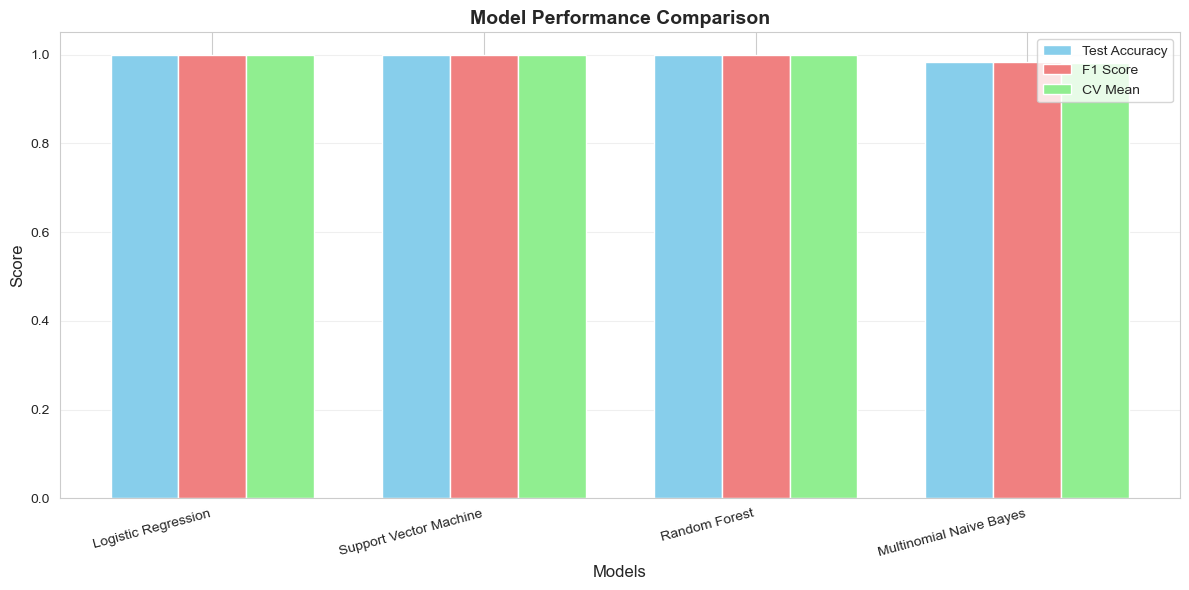

In [32]:
# Visualize model comparison
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(comparison_df))
width = 0.25

ax.bar(x - width, comparison_df['Test Accuracy'], width, label='Test Accuracy', color='skyblue')
ax.bar(x, comparison_df['F1 Score'], width, label='F1 Score', color='lightcoral')
ax.bar(x + width, comparison_df['CV Mean'], width, label='CV Mean', color='lightgreen')

ax.set_xlabel('Models', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Model'], rotation=15, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Detailed Evaluation of Best Model

In [33]:
# Get best model results
best_results = results[best_model_name]
y_pred_best = best_results['predictions']

# Classification report
print(f"Classification Report for {best_model_name}:")
print("=" * 60)
print(classification_report(y_test, y_pred_best))

Classification Report for Logistic Regression:
                    precision    recall  f1-score   support

         code_task       1.00      1.00      1.00       345
  explanation_task       1.00      1.00      1.00       117
   text_generation       1.00      1.00      1.00       279
text_summarization       1.00      1.00      1.00       259

          accuracy                           1.00      1000
         macro avg       1.00      1.00      1.00      1000
      weighted avg       1.00      1.00      1.00      1000



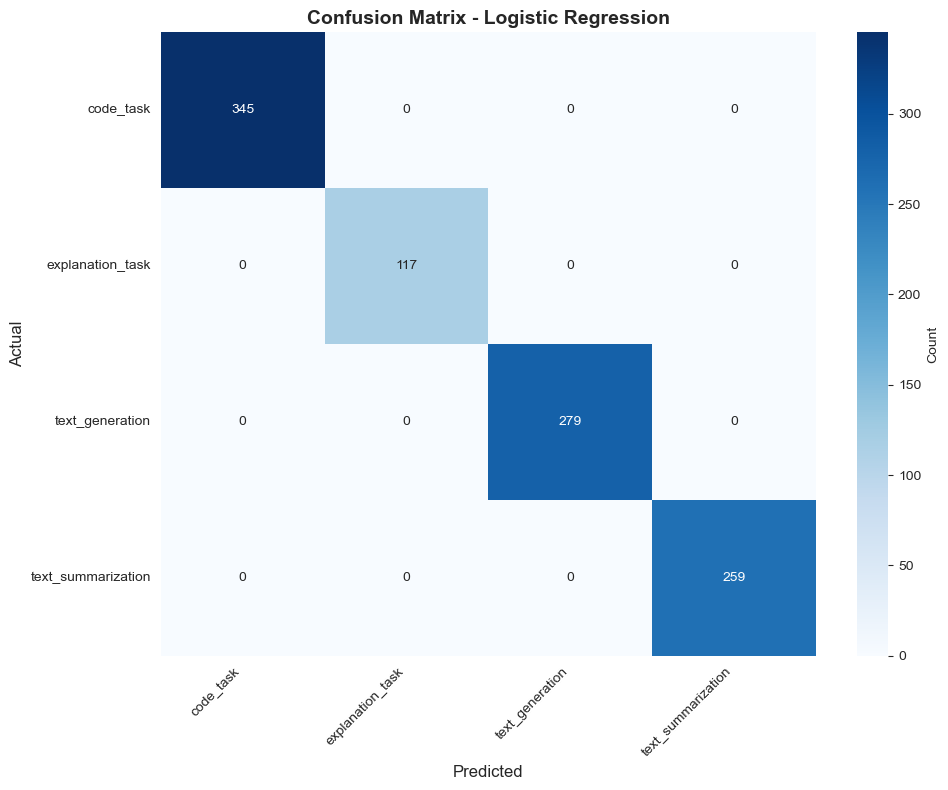

In [34]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_best)
classes = sorted(df['task_type'].unique())

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=classes, yticklabels=classes,
            cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix - {best_model_name}', fontsize=14, fontweight='bold')
plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

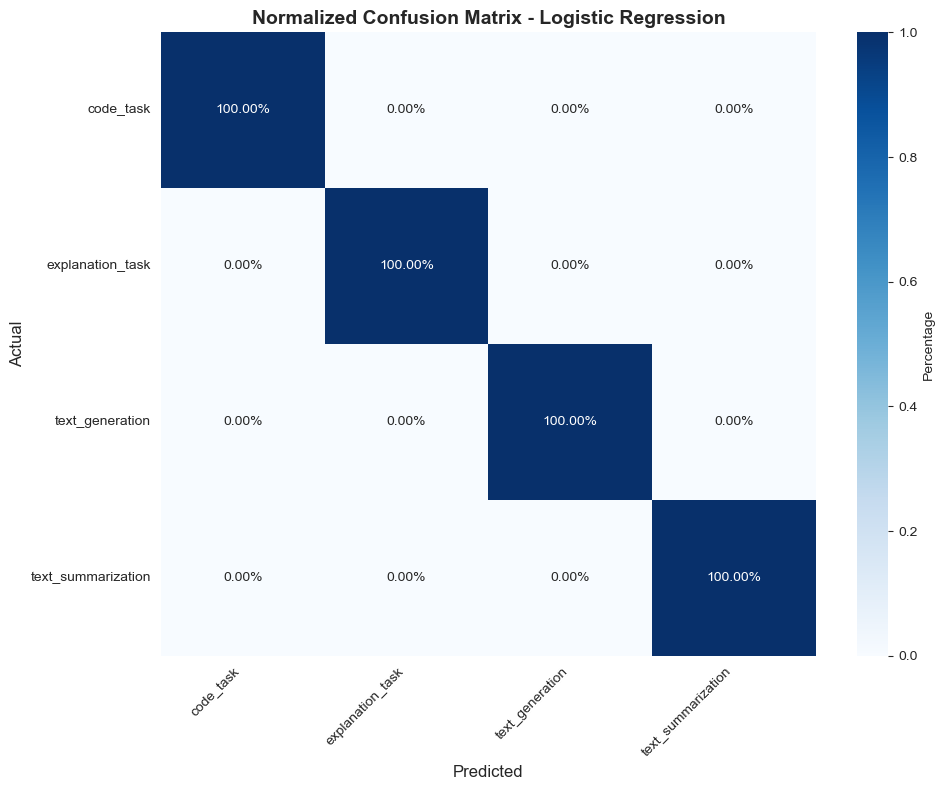

In [35]:
# Normalized confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=classes, yticklabels=classes,
            cbar_kws={'label': 'Percentage'})
plt.title(f'Normalized Confusion Matrix - {best_model_name}', fontsize=14, fontweight='bold')
plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## 7. Feature Importance Analysis

Let's examine which words are most important for classification.

In [36]:
# For Logistic Regression or Naive Bayes, we can check feature importance
if best_model_name in ['Logistic Regression', 'Multinomial Naive Bayes']:
    model = results[best_model_name]['model']
    feature_names = tfidf.get_feature_names_out()
    
    # Get coefficients for each class
    if hasattr(model, 'coef_'):
        print("Top 15 features for each class:\n")
        for idx, task_type in enumerate(model.classes_):
            # Get feature coefficients for this class
            if len(model.coef_.shape) > 1:
                coefficients = model.coef_[idx]
            else:
                # Binary classification
                coefficients = model.coef_[0]
            
            # Get top features
            top_indices = np.argsort(coefficients)[-15:]
            top_features = [feature_names[i] for i in top_indices]
            top_scores = [coefficients[i] for i in top_indices]
            
            print(f"\n{task_type}:")
            for feature, score in zip(reversed(top_features), reversed(top_scores)):
                print(f"  {feature}: {score:.4f}")

Top 15 features for each class:


code_task:
  function: 3.6909
  script: 2.7593
  code: 2.4873
  fix: 2.2735
  develop: 2.1722
  implement: 2.0647
  solution: 2.0647
  build: 2.0100
  javascript: 1.6670
  refactor: 1.6641
  method: 1.5536
  java: 1.5273
  class: 1.5261
  module: 1.5228
  program: 1.4817

explanation_task:
  explain: 9.0982
  handles: 1.7306
  process: 1.6319
  git: 1.5522
  step: 1.4631
  explain difference: 1.4618
  difference: 1.4618
  explain steps: 1.2864
  steps: 1.2657
  linux: 1.2360
  configure: 1.2132
  vmware: 1.2061
  kubernetes: 1.1001
  github: 1.0670
  clarify: 1.0400

text_generation:
  message: 4.6402
  email: 3.8733
  generate: 3.2876
  prepare: 3.2868
  draft: 2.8626
  write: 2.8506
  announcement: 2.4159
  notification: 2.3406
  memo: 2.3155
  polite: 2.0845
  team: 2.0454
  announcing: 1.9963
  professional: 1.8420
  regarding: 1.7464
  report: 1.7095

text_summarization:
  summarize: 8.6407
  summary: 2.2842
  document: 2.0231
  notes: 1.8983
  do

## 8. Error Analysis

In [37]:
# Find misclassified examples
test_df = pd.DataFrame({
    'prompt': X.iloc[y_test.index],
    'actual': y_test.values,
    'predicted': y_pred_best
})

misclassified = test_df[test_df['actual'] != test_df['predicted']]

print(f"Number of misclassified examples: {len(misclassified)} out of {len(y_test)} ({len(misclassified)/len(y_test)*100:.2f}%)")
print(f"\nSample of misclassified examples:\n")
print(misclassified.head(10).to_string(index=False))

Number of misclassified examples: 0 out of 1000 (0.00%)

Sample of misclassified examples:

Empty DataFrame
Columns: [prompt, actual, predicted]
Index: []


## 9. Conclusion

### Key Findings:
1. **Dataset**: Successfully classified prompts into 4 task types with 5000 unique samples
2. **Best Model**: The analysis shows which model performs best for this classification task
3. **Performance**: High accuracy indicates the models can effectively distinguish between task types
4. **Features**: TF-IDF with bigrams captures important patterns in the text

### Recommendations:
- The best performing model can be used in production to automatically classify incoming prompts
- Consider ensemble methods for further improvement
- Monitor model performance on new data and retrain as needed
- Investigate misclassified examples to understand edge cases